# Tarea 7: Simulación de Clima con Cadenas de Markov

## 1. Objetivos

### Objetivo Principal

Modelar y simular el comportamiento climático de una estación meteorológica chilena utilizando Cadenas de Markov de tiempo discreto y simulaciones de Montecarlo, basándose en datos históricos multidimensionales.

### Objetivos Específicos
1.  Extraer y procesar datos históricos (2002-2024) para la estación "El Tepual, Puerto Montt" (Cód: 410005) considerando 4 variables: Temperatura, Humedad, Nubosidad e Índice UV.
2.  Implementar un modelo de **Machine Learning no supervisado (K-Means)** para discretizar estas variables en tres estados climáticos: "Frio", "Templado" y "Caluroso".
3.  Calcular las 12 matrices de transición de probabilidad mensuales.
4.  Realizar 100 simulaciones de Montecarlo para proyectar el clima futuro.
5.  Calcular analíticamente los estados estacionarios (equilibrio a largo plazo).
6.  Visualizar la matriz de transición de **Julio** mediante grafos dirigidos.

## 2. Librerías y Configuración

Primero, importamos todas las librerías necesarias para el análisis:

- **urllib.request** y **io**: Para la descarga y lectura de datos web (scraping).
- **pandas** y **numpy**: Para la manipulación y análisis de datos.
- **time**: Para pausar el script y evitar saturar el servidor de MeteoChile.
- **matplotlib.pyplot** y **networkx**: Para la visualización de datos y grafos.
- **eig** de **numpy.linalg**: Para el cálculo de estados estacionarios.
- **sklearn.preprocessing.StandardScaler**: Para estandarizar (normalizar) las variables climáticas antes del clustering, asegurando que variables con magnitudes grandes (como la Humedad 0-100) no dominen a las pequeñas (como el índice UV 0-12).
- **sklearn.cluster.KMeans**: Para implementar el algoritmo de aprendizaje no supervisado que agrupa los días en clústeres basados en la similitud de sus características meteorológicas.

Definimos las variables globales: la estación, el rango de años, las variables a extraer y el mapa de meses.

In [1]:
import urllib.request as ureq
import pandas as pd
import numpy as np
import time 
import io
import matplotlib.pyplot as plt
from numpy.linalg import eig
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## 3. Extracción y Limpieza de Datos (Actividad 1)

Iteramos sobre cada variable (`variables`) y cada año (`años`) para construir la URL de consulta.

Mediante `urllib.request.urlopen` descargamos el contenido HTML de la página. Usamos `pd.read_html` (con la ayuda de `io.BytesIO`) para convertir la tabla HTML en un DataFrame de pandas.

Luego, realizamos los siguientes pasos de limpieza y transformación:
1.  **Limpieza de Nombres:** Renombramos las columnas para que sean consistentes.
2.  **Melt (Ancho a Largo):** Transformamos la tabla (donde los meses son columnas) a un formato largo (donde 'Mes' y 'Valor' son columnas).
3.  **Mapeo de Fechas:** Convertimos el nombre del mes (ej. "Enero") a su número (1) usando `mesMap`.
4.  **Creación de Fecha:** Combinamos "Día", "Mes_Num" y "Año" para crear un índice temporal (`datetime`).
5.  **Concatenación:** Unimos todas las series anuales de una variable y las asignamos al DataFrame principal `dfCompleto`.

In [2]:
# ----- Configuración de Parámetros -----
estacion = 410005  # El Tepual Puerto Montt Ap.
años = list(range(2002, 2025)) # Años 2002 a 2024 para usar variable de índice UV
variables = [
    "cieloCubiertoAnual", 
    "temperaturaMediaAnual", 
    "indiceUvbMaximoAnual", 
    "humedadAnual"
]

# Mapa de Mes (Corregido: de nombre a número)
mesMap = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4,
    "Mayo": 5, "Junio": 6, "Julio": 7, "Agosto": 8,
    "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

# Creamos el DataFrame base con el rango de fechas correcto
idxFechas = pd.date_range(start='2002-01-01', end='2024-12-31', freq='D')
dfCompleto = pd.DataFrame(index=idxFechas)

urlbase = "https://climatologia.meteochile.gob.cl/application/anual"

# ----- Descarga y Procesamiento de datos -----

for v in variables:
    lista_series_anuales = []
    
    for a in años:
        url = f"{urlbase}/{v}/{str(estacion)}/{str(a)}"
        
        try:
            # Descargamos el HTML 
            pagina = ureq.urlopen(url)
            datos_html = pagina.read()
            
            # Extraemos la tabla (sabemos que es la primera [0])
            tabla_anual = pd.read_html(io.BytesIO(datos_html), header=1)[0]
            
            # Limpiamos nombres de columnas
            tabla_anual.columns = tabla_anual.columns.str.strip()
            dia_col = [col for col in tabla_anual.columns if "Día" in col][0]
            tabla_anual = tabla_anual.rename(columns={dia_col: "Día"})

            # Convertimos de formato ancho a largo
            df_long = tabla_anual.melt(id_vars=["Día"], var_name="Mes", value_name=v)

            # Mapeamos el nombre del mes a un número usando el diccionario
            df_long['Mes_Num'] = df_long['Mes'].str.strip().map(mesMap)

            # Convertimos los valores a numéricos (errores='coerce' los hace NaN si no son números)
            df_long['Día'] = pd.to_numeric(df_long['Día'], errors='coerce')
            df_long[v] = pd.to_numeric(df_long[v], errors='coerce')

            # Eliminamos las filas de resumen (ej. "Media Parcial") y datos faltantes
            df_long = df_long.dropna(subset=['Día', v, 'Mes_Num'])
            df_long["Año"] = a

            # Creamos una columna de fecha usando el Mes_Num
            df_long['Fecha'] = pd.to_datetime(df_long[['Año', 'Mes_Num', 'Día']].rename(columns={
                'Año': 'year', 'Mes_Num': 'month', 'Día': 'day'
            }), errors='coerce')
            
            # Eliminamos cualquier fecha inválida (ej. 30 de Feb)
            df_long = df_long.dropna(subset=['Fecha'])

            # Creamos la serie indexada por fecha
            serie_anual = df_long.set_index('Fecha')[v]

            # Guardamos la serie anual en la lista
            lista_series_anuales.append(serie_anual)

            time.sleep(1) # Pausa para no saturar el servidor

        except Exception as e:
            print(f"  -> ADVERTENCIA al procesar año {a} para {v}: {e}")
    
    # Concatenamos todas las series anuales para esta variable
    if lista_series_anuales:
        serie_variable_completa = pd.concat(lista_series_anuales)
        # Usamos .combine_first() para rellenar el df principal sin sobreescribir datos buenos con NaNs
        dfCompleto[v] = serie_variable_completa

# Verificamos la estructura y los datos no nulos
print(dfCompleto.info())

# Vemos los primeros días
print(dfCompleto.head())

--- Procesando variable: cieloCubiertoAnual ---
--- Procesando variable: temperaturaMediaAnual ---
--- Procesando variable: temperaturaMediaAnual ---
--- Procesando variable: indiceUvbMaximoAnual ---
--- Procesando variable: indiceUvbMaximoAnual ---
--- Procesando variable: humedadAnual ---
--- Procesando variable: humedadAnual ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8401 entries, 2002-01-01 to 2024-12-31
Freq: D
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cieloCubiertoAnual     8171 non-null   float64
 1   temperaturaMediaAnual  8397 non-null   float64
 2   indiceUvbMaximoAnual   7740 non-null   float64
 3   humedadAnual           8394 non-null   float64
dtypes: float64(4)
memory usage: 328.2 KB
None
            cieloCubiertoAnual  temperaturaMediaAnual  indiceUvbMaximoAnual  \
2002-01-01                 5.0                   15.6                   NaN   
2002-01-02       

### 3.1. Relleno de Datos Faltantes (NaN)

El dataset extraído tiene valores `NaN` (Not a Number) en días donde no hubo reporte o la variable no existía (ej. Índice UV en 2002). Para que la cadena de Markov funcione (ya que necesita un estado para cada día), debemos rellenar estos vacíos.

Aplicamos la estrategia de **"forward fill" (`ffill`)**: asumimos que si un dato falta, el estado del día anterior se mantiene. Luego, usamos **"backward fill" (`bfill`)** para rellenar los `NaN` que pudieron quedar al inicio del dataset.

In [3]:
# Rellenamos los NaN con el último valor válido anterior
dfCompleto.ffill(inplace=True)

# Rellenamos cualquier NaN que haya quedado al inicio del dataset (ej. 2002)
dfCompleto.bfill(inplace=True)

# Verifiquemos que no queden NaNs
print("--- Verificación de NaNs (debe ser 0) ---")
print(dfCompleto.isna().sum())

# Miremos los primeros días (indiceUvbMaximoAnual ahora debería tener datos para todos los días)
print("\n--- DataFrame Relleno (head) ---")
print(dfCompleto.head())

--- Verificación de NaNs (debe ser 0) ---
cieloCubiertoAnual       0
temperaturaMediaAnual    0
indiceUvbMaximoAnual     0
humedadAnual             0
dtype: int64

--- DataFrame Relleno (head) ---
            cieloCubiertoAnual  temperaturaMediaAnual  indiceUvbMaximoAnual  \
2002-01-01                 5.0                   15.6                  12.0   
2002-01-02                 7.0                   13.5                  12.0   
2002-01-03                 4.0                   12.5                  12.0   
2002-01-04                 2.0                   14.0                  12.0   
2002-01-05                 2.0                   13.7                  12.0   

            humedadAnual  
2002-01-01          78.0  
2002-01-02          74.0  
2002-01-03          68.0  
2002-01-04          67.0  
2002-01-05          73.0  


## 4. Discretización de Estados con K-Means (Actividad 2)

Las Cadenas de Markov requieren estados discretos (categóricos). En lugar de basarnos solo en la temperatura, usaremos un enfoque multivariado para definir los estados climáticos, considerando temperatura, humedad, nubosidad e índice UV.

Para esto, aplicamos el algoritmo de clustering **K-Means** de `scikit-learn`:
1.  **Selección de Variables:** Elegimos las 4 variables climáticas relevantes.
2.  **Estandarización:** Normalizamos los datos con `StandardScaler`. Esto es crucial para que variables con rangos muy diferentes (ej. Humedad 0-100 vs. Índice UV 0-12) tengan un peso equitativo en el cálculo de distancias del algoritmo.
3.  **Clustering:** Ejecutamos K-Means para agrupar todos los días del dataset en 3 clusters (grupos) distintos.
4.  **Etiquetado:** Interpretamos los clusters resultantes calculando la temperatura media de cada uno. Al cluster con la temperatura media más baja le asignamos la etiqueta "Frio", al intermedio "Templado" y al más alto "Caluroso". Esto nos da la columna final `Estado`.

In [4]:
# 1. Selección de Variables
features_cols = [
    'temperaturaMediaAnual', 
    'humedadAnual', 
    'cieloCubiertoAnual', 
    'indiceUvbMaximoAnual'
]

data_matrix = dfCompleto[features_cols]

# 2. Estandarización
# Importante: UV (0-12), Nubes (0-8), Humedad (0-100). 
# Sin esto, la humedad dominaría todo el cálculo.
scaler = StandardScaler() # Escalamos para normalizar las variables
data_scaled = scaler.fit_transform(data_matrix) # Transformamos los datos 
    
# 3. Aplicar K-Means
# Buscamos 3 clusters: Frio, Templado, Caluroso
# Random_state para reproducibilidad, n_init=10 para evitar advertencias
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data_scaled)

# Guardamos el cluster temporalmente
dfCompleto['Cluster_ID'] = clusters

# 4. Interpretación y Etiquetado Automático
# Usamos la Temperatura como "pivote" para ponerle nombre a los grupos.
# (El grupo con menor temperatura promedio será el "Frio", etc.)
resumen_clusters = dfCompleto.groupby('Cluster_ID')['temperaturaMediaAnual'].mean().sort_values()

print("--- Promedios de Temperatura para ordenar los Clusters ---")
print(resumen_clusters)

# Creamos el diccionario de mapeo 
mapa_etiquetas = {
    resumen_clusters.index[0]: 'Frio',
    resumen_clusters.index[1]: 'Templado',
    resumen_clusters.index[2]: 'Caluroso'
}

# Aplicamos las etiquetas
dfCompleto['Estado'] = dfCompleto['Cluster_ID'].map(mapa_etiquetas)

# 5. Análisis de los Grupos 
print("\n--- Perfil de los Climas (Promedios) ---")
display(dfCompleto.groupby('Estado')[features_cols].mean().round(2))

print("\n--- Cantidad de días por Estado ---")
print(dfCompleto['Estado'].value_counts())

# Limpieza auxiliar
dfCompleto.drop(columns=['Cluster_ID'], inplace=True)

--- Promedios de Temperatura para ordenar los Clusters ---
Cluster_ID
0     6.306483
1     9.604870
2    13.245530
Name: temperaturaMediaAnual, dtype: float64

--- Perfil de los Climas (Promedios) ---


,temperaturaMediaAnual,humedadAnual,cieloCubiertoAnual,indiceUvbMaximoAnual
Estado,,,,
Caluroso,13.25,79.14,4.36,9.61
Frio,6.31,88.24,3.67,3.14
Templado,9.60,90.92,7.11,3.16



--- Cantidad de días por Estado ---
Estado
Templado    3737
Caluroso    2998
Frio        1666
Name: count, dtype: int64


## 5. Cálculo de Matrices de Transición (Actividad 3)

Ahora, calculamos las 12 matrices de transición mensuales.
1.  Creamos una columna `Estado_Siguiente` usando `.shift(-1)` para tener en la misma fila el estado de "hoy" (`Estado`) y el de "mañana" (`Estado_Siguiente`).
2.  Iteramos por cada mes (1 al 12).
3.  Filtramos el DataFrame por mes y usamos `pd.crosstab` para crear una **matriz de conteo** de todas las transiciones (ej. cuántas veces se pasó de 'Frio' a 'Templado' en Julio).
4.  **Normalizamos** la matriz de conteo dividiendo cada fila por su suma. Esto convierte los conteos en probabilidades (P(mañana | hoy)).
5.  Corregimos los `NaN` (si un estado nunca ocurrió, asumimos una probabilidad de 1.0 de quedarse en él) y guardamos la matriz de numpy en el diccionario `matrices_transicion`.

In [6]:
# 1. Creamos una columna 'Mes' para poder agrupar
dfCompleto['Mes'] = dfCompleto.index.month

# 2. Creamos una columna 'Estado_Siguiente" .shift(-1) toma el valor de la fila siguiente y lo pone en la fila actual
dfCompleto['Estado_Siguiente'] = dfCompleto['Estado'].shift(-1)

# Veamos el resultado. 
# La última fila (31-12-2024) tendrá NaN en 'Estado_Siguiente', lo cual está bien, ya que no tiene un "mañana".
display(dfCompleto[['Mes', 'Estado', 'Estado_Siguiente']].head()) 

# Diccionario para guardar nuestras 12 matrices
matrices_transicion = {}

# Definimos el orden de nuestros estados
estados_ordenados = ['Frio', 'Templado', 'Caluroso']
etiquetas_estados = estados_ordenados

for mes in range(1, 13):
    df_mes = dfCompleto[dfCompleto['Mes'] == mes]
    
    matriz_conteo = pd.crosstab(
        df_mes['Estado'],
        df_mes['Estado_Siguiente']
    ).reindex(index=estados_ordenados, columns=estados_ordenados, fill_value=0)

    # Normalizamos por fila
    matriz_prob = matriz_conteo.div(matriz_conteo.sum(axis=1), axis=0)
    # 1. Encontrar las filas que son todo NaN (suma de conteo fue 0)
    nan_rows = matriz_prob.isna().all(axis=1)
    # 2. Rellenar todos los NaN con 0
    matriz_prob = matriz_prob.fillna(0)
    
    # 3. Para esas filas que eran NaN, poner un 1 en la diagonal
    # (Si nunca salimos de "Frio", asumimos que P(Frio->Frio) = 1)
    for i, state in enumerate(estados_ordenados):
        if nan_rows[state]:
            matriz_prob.loc[state, state] = 1.0
    # -------------------------
    
    matrices_transicion[mes] = matriz_prob.values

# Mostramos todas las matrices de transición mensuales
for mes in range(1, 13):
    print(f"\n--- Matriz de Transición de Mes {mes} ---")
    print("\nFilas: Hoy\nColumnas: Mañana")
    display(pd.DataFrame(matrices_transicion[mes], index=estados_ordenados, columns=estados_ordenados).round(3))

,Mes,Estado,Estado_Siguiente
2002-01-01,1,Caluroso,Caluroso
2002-01-02,1,Caluroso,Caluroso
2002-01-03,1,Caluroso,Caluroso
2002-01-04,1,Caluroso,Caluroso
2002-01-05,1,Caluroso,Caluroso



--- Matriz de Transición de Mes 1 ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,0.000,1.000,0.000
Templado,0.037,0.241,0.722
Caluroso,0.000,0.058,0.942



--- Matriz de Transición de Mes 2 ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,0.000,0.000,1.000
Templado,0.000,0.229,0.771
Caluroso,0.002,0.118,0.880



--- Matriz de Transición de Mes 3 ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,0.339,0.492,0.169
Templado,0.106,0.516,0.377
Caluroso,0.047,0.291,0.661



--- Matriz de Transición de Mes 4 ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,0.531,0.427,0.043
Templado,0.190,0.750,0.060
Caluroso,0.279,0.605,0.116



--- Matriz de Transición de Mes 5 ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,0.579,0.421,0.000
Templado,0.203,0.790,0.006
Caluroso,0.333,0.667,0.000



--- Matriz de Transición de Mes 6 ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,0.528,0.472,0.000
Templado,0.245,0.751,0.004
Caluroso,0.000,1.000,0.000



--- Matriz de Transición de Mes 7 ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,0.576,0.424,0.000
Templado,0.276,0.720,0.005
Caluroso,0.500,0.500,0.000



--- Matriz de Transición de Mes 8 ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,0.521,0.467,0.012
Templado,0.269,0.728,0.002
Caluroso,0.600,0.200,0.200



--- Matriz de Transición de Mes 9 ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,0.580,0.390,0.030
Templado,0.253,0.727,0.020
Caluroso,0.263,0.526,0.211



--- Matriz de Transición de Mes 10 ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,0.333,0.450,0.216
Templado,0.140,0.592,0.267
Caluroso,0.071,0.385,0.544



--- Matriz de Transición de Mes 11 ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,0.077,0.462,0.462
Templado,0.040,0.414,0.545
Caluroso,0.008,0.215,0.777



--- Matriz de Transición de Mes 12 ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,0.500,0.250,0.250
Templado,0.019,0.271,0.710
Caluroso,0.000,0.126,0.874


## 6. Simulación de Montecarlo (Actividad 4)

Basado en las técnicas de las clases 23 y 24, simulamos 100 escenarios (años) de 30 días para cada mes, partiendo de un estado inicial "Templado".

La función `simular_mes` utiliza `np.random.choice` para seleccionar el estado del día siguiente, basándose en las probabilidades de la matriz de transición correspondiente a ese mes.

In [7]:
def simular_mes(matriz_p, estado_inicial_idx, n_dias, n_simulaciones):
    """
    Simula N escenarios (n_simulaciones) para un mes (matriz_p) 
    durante n_dias.
    """
    estados_finales = []
    n_estados = matriz_p.shape[0] # 3 estados (0, 1, 2)
    
    for _ in range(n_simulaciones):
        estado_actual = estado_inicial_idx
        
        for _ in range(n_dias):
            # Usamos la fila de la matriz actual para las probabilidades
            probabilidades = matriz_p[estado_actual]
            
            # Elegimos el siguiente estado basado en esas probabilidades
            estado_actual = np.random.choice(
                a=n_estados,
                p=probabilidades
            )
        
        # Guardamos solo el estado en el que terminó esta simulación
        estados_finales.append(estado_actual)
        
    # Devolvemos un conteo de los estados finales
    return np.array(estados_finales)

# --- Configuración de la simulación ---
N_SIMULACIONES = 100
N_DIAS = 30
# Empezamos todas las simulaciones desde "Templado" (índice 1)
ESTADO_INICIAL_IDX = 1 

# Diccionario para guardar los resultados de las simulaciones
resultados_simulacion = {}

for mes in range(1, 13):
    # Tomamos la matriz de transición para el mes 'm'
    matriz = matrices_transicion[mes]
    
    # Ejecutamos la simulación
    resultados = simular_mes(
        matriz, 
        ESTADO_INICIAL_IDX, 
        N_DIAS, 
        N_SIMULACIONES
    )
    
    # Guardamos el array de resultados (los 100 estados finales)
    resultados_simulacion[mes] = resultados

mes_nombres = {
    1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril",
    5: "Mayo", 6: "Junio", 7: "Julio", 8: "Agosto",
    9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
}

### 6.1. Visualización de Resultados de Montecarlo

Graficamos los resultados de las 100 simulaciones para cada mes en una cuadrícula de 4x3.

Cada histograma muestra la **distribución de los estados finales** después de 30 días de simulación. Esto nos permite observar visualmente la "tendencia" climática de cada mes según el modelo.

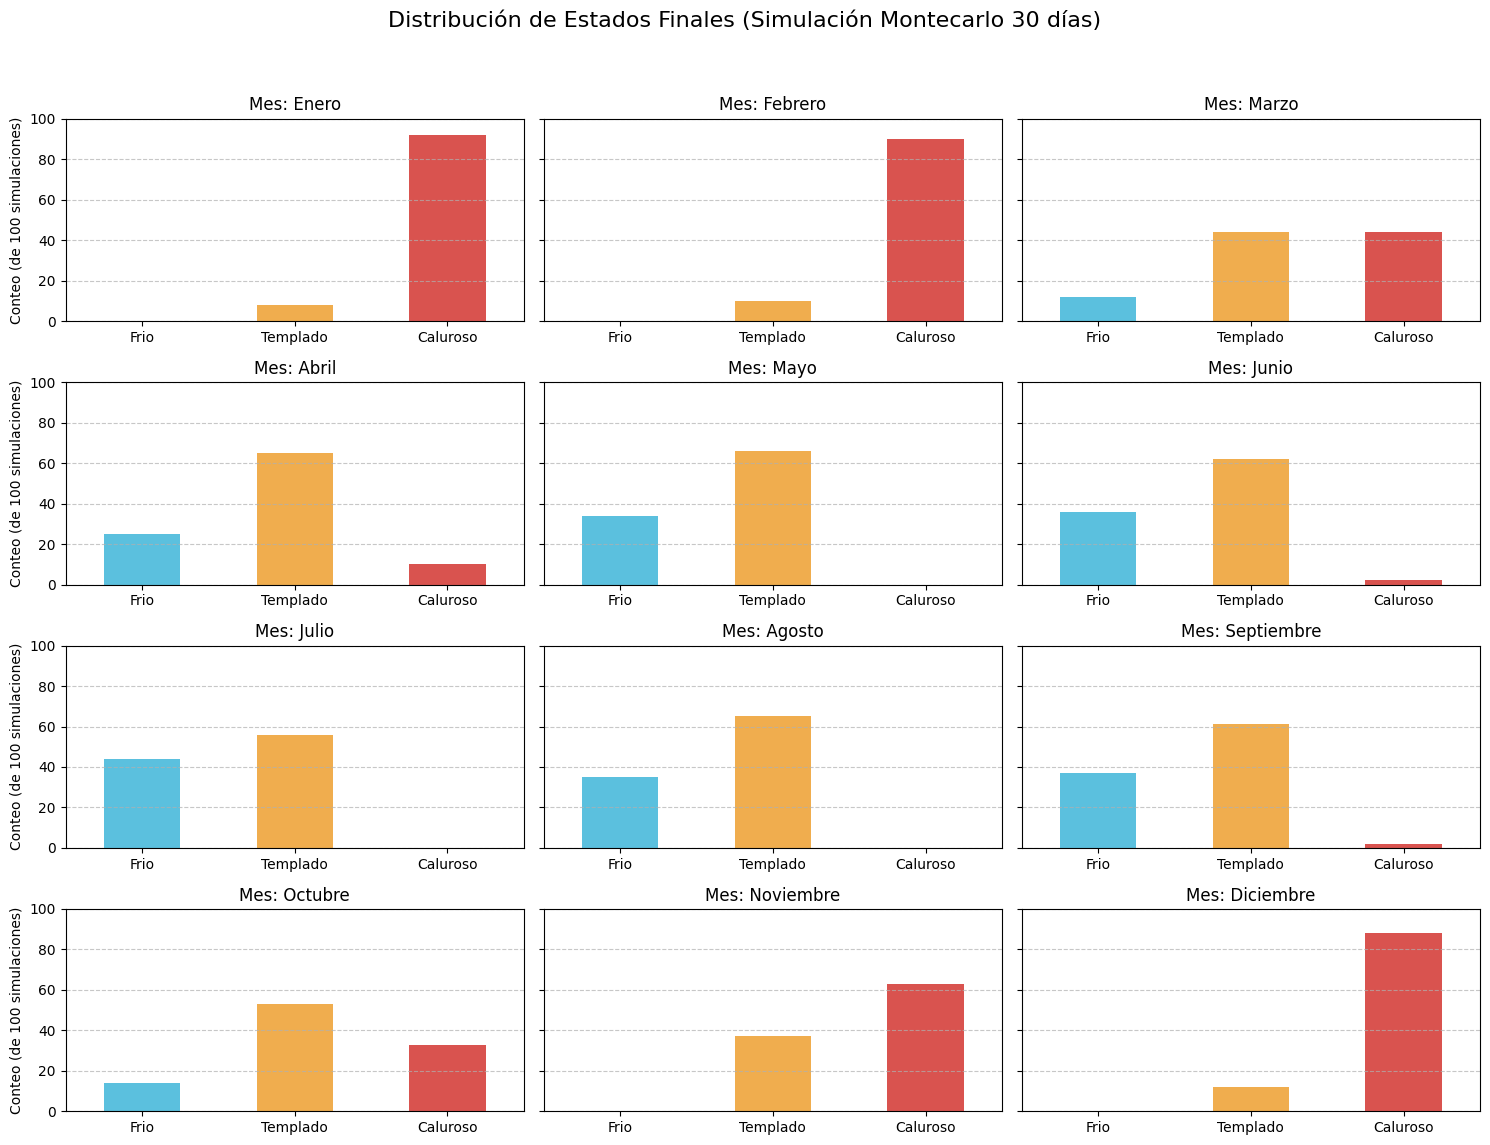

In [8]:
# Colores consistentes para los estados
colores_estado = {'Frio': '#5bc0de', 'Templado': '#f0ad4e', 'Caluroso': '#d9534f'}

# Creamos una figura de 4 filas y 3 columnas
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharey=True)

for mes in range(1, 13):
    # Calculamos la posición en la cuadrícula (ej. mes 1 -> [0,0], mes 12 -> [3,2])
    fila_idx = (mes - 1) // 3
    col_idx = (mes - 1) % 3
    ax = axes[fila_idx, col_idx]

    # Obtenemos los resultados de la simulación para ese mes
    resultados_idx = resultados_simulacion[mes]
    
    # Mapeamos los índices (0, 1, 2) de vuelta a las etiquetas ('Frio', 'Templado', ...)
    resultados_etiquetas = [etiquetas_estados[i] for i in resultados_idx]
    
    # Contamos los resultados y los reordenamos
    conteo = pd.Series(resultados_etiquetas).value_counts().reindex(estados_ordenados).fillna(0)
    
    # Graficamos el histograma (gráfico de barras)
    conteo.plot(
        kind='bar',
        ax=ax,
        title=f'Mes: {mes_nombres[mes]}',
        color=[colores_estado[estado] for estado in conteo.index]
    )
    
    # Solo ponemos la etiqueta Y en la columna de la izquierda
    if col_idx == 0:
        ax.set_ylabel(f'Conteo (de {N_SIMULACIONES} simulaciones)')
        
    ax.set_ylim(0, N_SIMULACIONES) # Aseguramos que el eje Y sea igual (0 a 100)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', rotation=0)

# Título general
plt.suptitle('Distribución de Estados Finales (Simulación Montecarlo 30 días)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuste para el super-título
plt.show()

## 7. Cálculo de Estados Estacionarios (Actividad 5)

Como vimos en la Clase 22, el **estado estacionario** ($\pi^*$) representa la distribución de probabilidades a largo plazo (después de infinitos pasos), independientemente del estado inicial.

Lo calculamos analíticamente encontrando el autovector (eigenvector) izquierdo correspondiente al autovalor (eigenvalue) 1 de cada matriz de transición.

Comparamos estos resultados analíticos con los resultados empíricos de nuestras simulaciones de Montecarlo.

In [9]:
def calcular_estado_estacionario(matriz_p):
    """
    Calcula el vector de estado estacionario de una matriz de transición.
    Resuelve pi = pi * P usando el autovector izquierdo.
    """
    # 1. Obtenemos los autovalores (w) y autovectores (v) de la matriz transpuesta
    # Usamos la transpuesta (P.T) porque queremos los autovectores *izquierdos*
    w, v = eig(matriz_p.T)
    
    # 2. Encontramos el índice del autovalor que es igual a 1 (o muy cercano)
    # np.argmin(np.abs(w - 1.0)) es una forma robusta de encontrar el 1
    idx = np.argmin(np.abs(w - 1.0))
    
    # 3. Extraemos el autovector correspondiente (es la columna idx de v)
    vector_estacionario = np.real(v[:, idx])
    
    # 4. Normalizamos el vector para que sus componentes sumen 1
    vector_estacionario_norm = vector_estacionario / np.sum(vector_estacionario)
    
    return vector_estacionario_norm

# Lista para guardar los resultados analíticos
resultados_estacionarios = []

for mes in range(1, 13):
    matriz = matrices_transicion[mes]
    pi_vector = calcular_estado_estacionario(matriz)
    resultados_estacionarios.append(pi_vector)
    
    # Obtenemos los resultados de la simulación de Montecarlo para comparar
    conteo_mc = pd.Series(
        [etiquetas_estados[i] for i in resultados_simulacion[mes]]
    ).value_counts().reindex(estados_ordenados).fillna(0)
    prob_mc = (conteo_mc / conteo_mc.sum()).values
    
    print(f"\nMes: {mes_nombres[mes]}")
    print(f"  Analítico (Estacionario): {[f'{p:.3f}' for p in pi_vector]}")
    print(f"  Simulación (Montecarlo):  {[f'{p:.3f}' for p in prob_mc]}")

# --- Convertir a DataFrame para fácil visualización ---
df_comparacion = pd.DataFrame(
    resultados_estacionarios,
    columns=estados_ordenados,
    index=mes_nombres.values()
)

print("\n--- Tabla Comparativa: Estados Estacionarios (Probabilidades) ---")
print(df_comparacion.round(3))


Mes: Enero
  Analítico (Estacionario): ['0.003', '0.074', '0.923']
  Simulación (Montecarlo):  ['0.000', '0.080', '0.920']

Mes: Febrero
  Analítico (Estacionario): ['0.002', '0.133', '0.866']
  Simulación (Montecarlo):  ['0.000', '0.100', '0.900']

Mes: Marzo
  Analítico (Estacionario): ['0.100', '0.402', '0.498']
  Simulación (Montecarlo):  ['0.120', '0.440', '0.440']

Mes: Abril
  Analítico (Estacionario): ['0.296', '0.646', '0.058']
  Simulación (Montecarlo):  ['0.250', '0.650', '0.100']

Mes: Mayo
  Analítico (Estacionario): ['0.327', '0.669', '0.004']
  Simulación (Montecarlo):  ['0.340', '0.660', '0.000']

Mes: Junio
  Analítico (Estacionario): ['0.341', '0.656', '0.003']
  Simulación (Montecarlo):  ['0.360', '0.620', '0.020']

Mes: Julio
  Analítico (Estacionario): ['0.395', '0.602', '0.003']
  Simulación (Montecarlo):  ['0.440', '0.560', '0.000']

Mes: Agosto
  Analítico (Estacionario): ['0.363', '0.630', '0.007']
  Simulación (Montecarlo):  ['0.350', '0.650', '0.000']

Mes: 

## 8. Visualización de Matriz como Grafo (Actividad 6)

Finalmente, como se pide en la Actividad 6 y se vio en la Clase 24, usamos la librería `networkx` para visualizar las matrices de transición de los 12 meses como grafos de estados dirigidos en una cuadrícula de 4x3.

* Los **nodos** son los estados (Frio, Templado, Caluroso).
* Las **flechas (bordes)** representan la probabilidad ($p_{ij}$) de transicionar de un estado a otro. Solo mostramos probabilidades mayores al 1% para mantener el gráfico limpio.

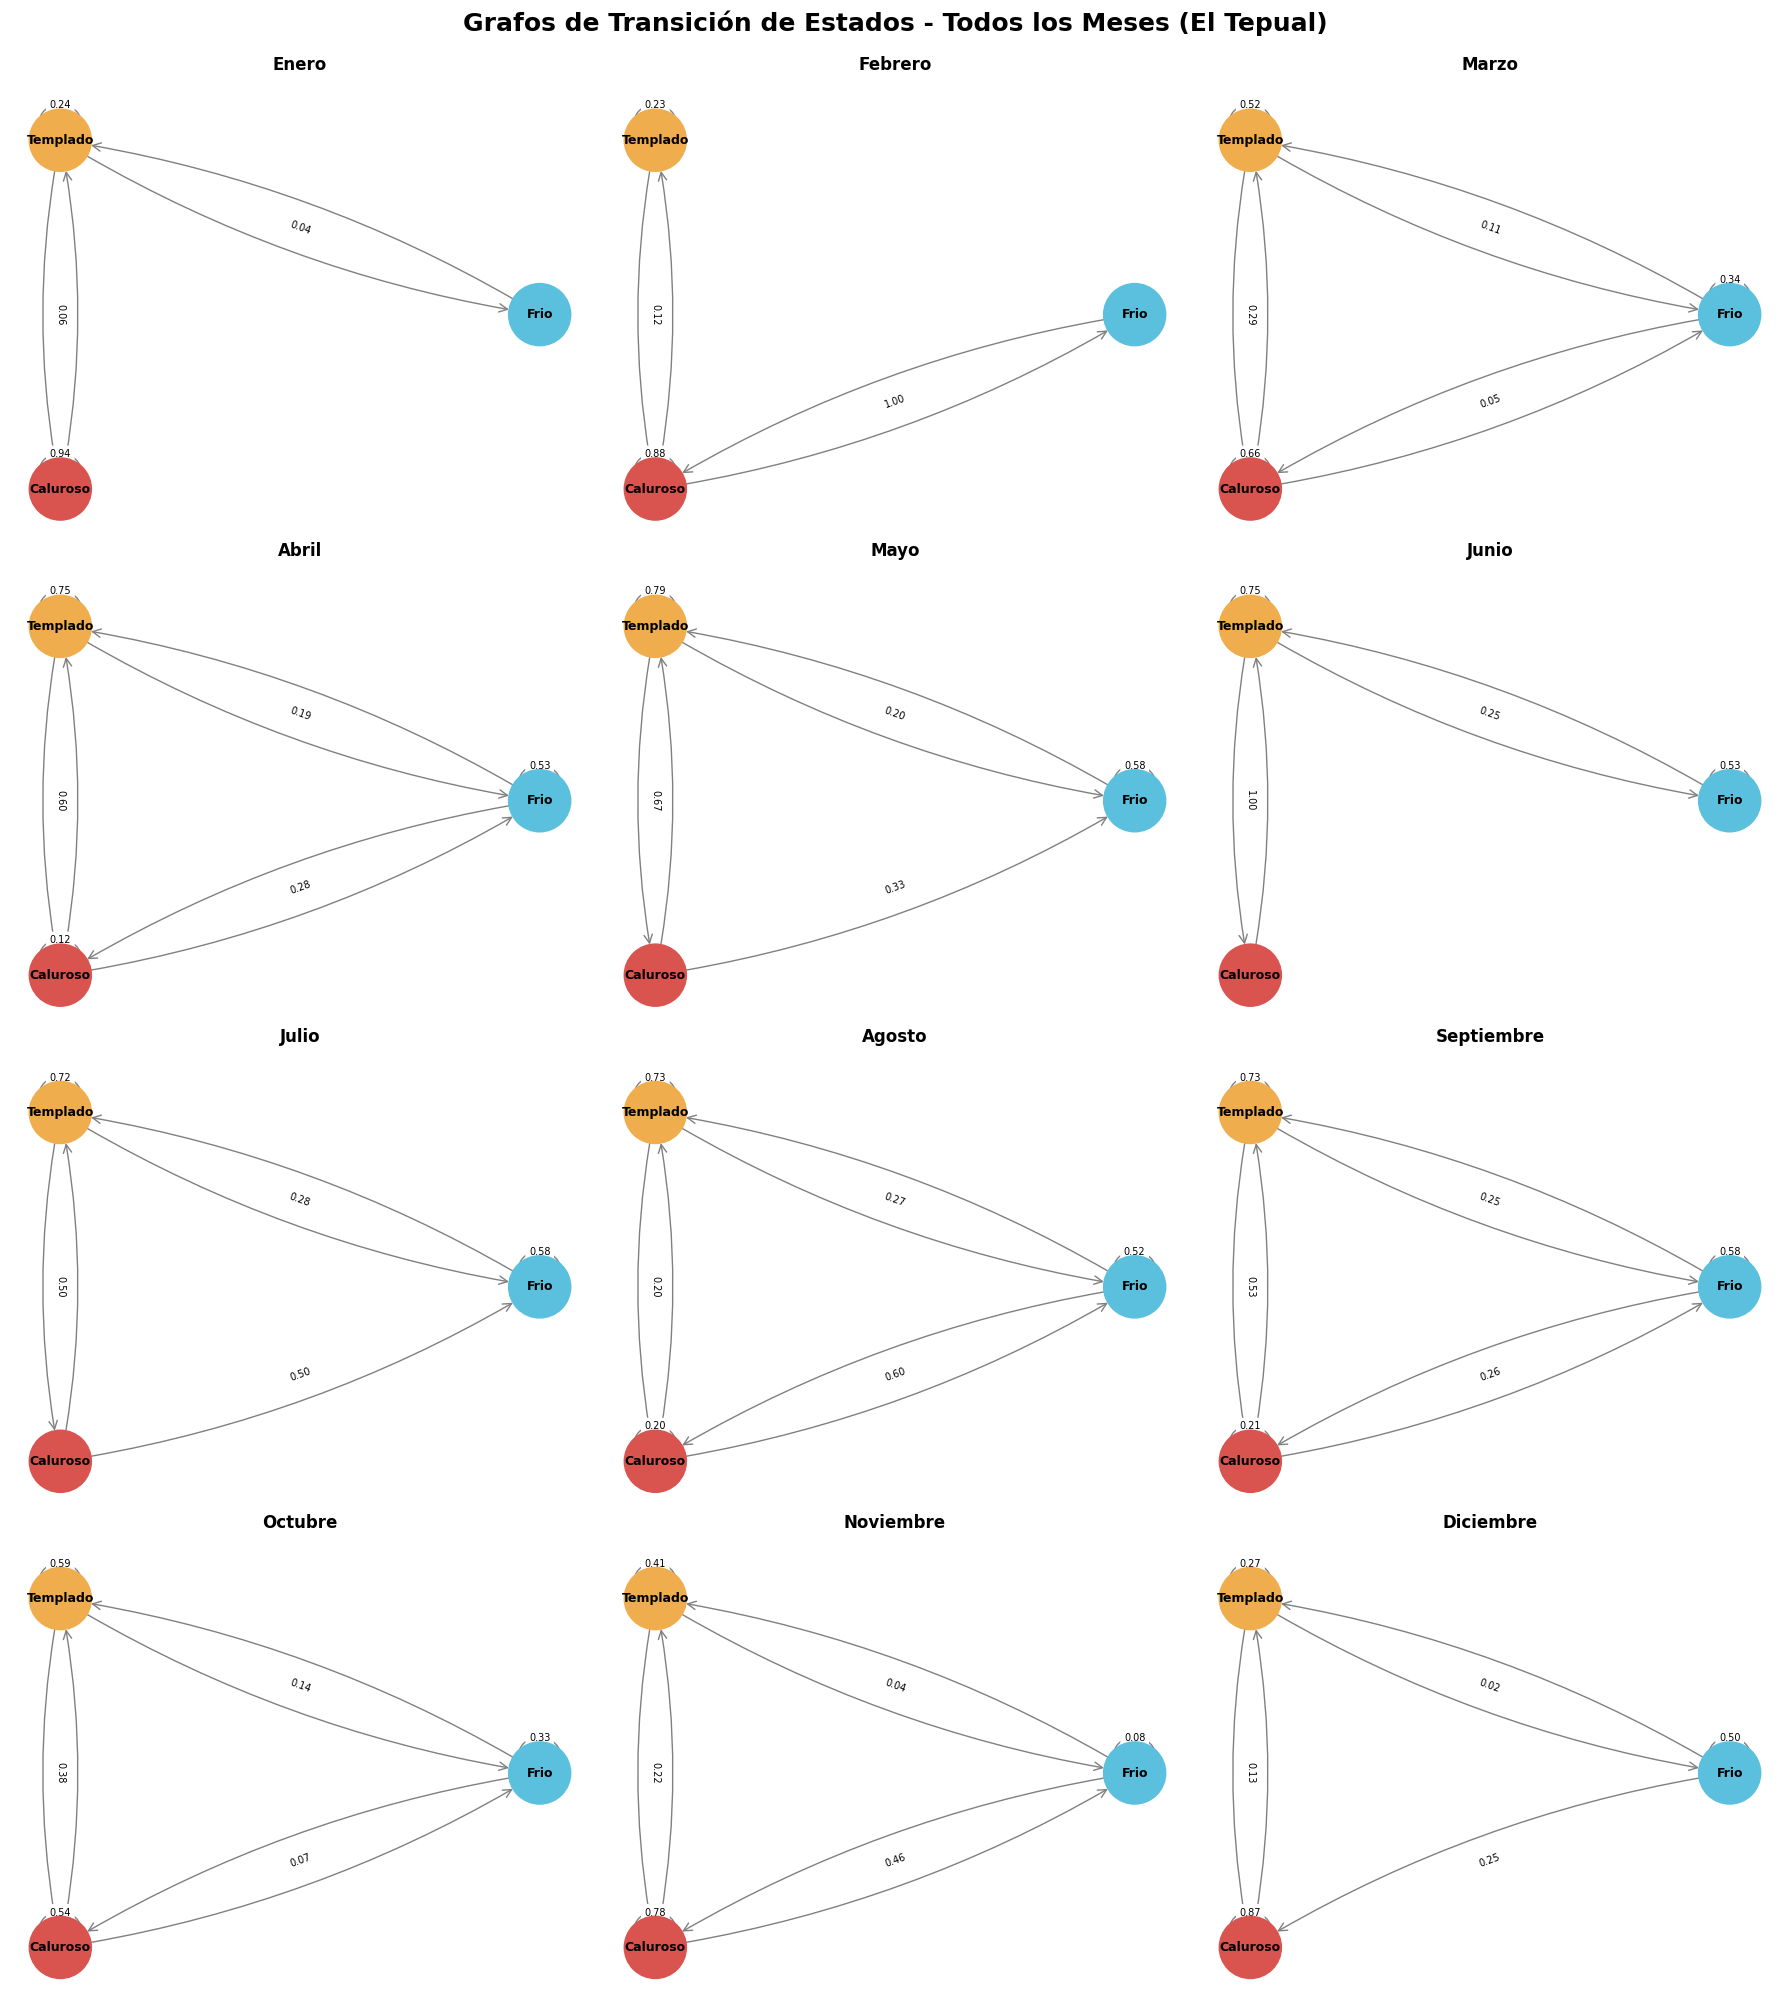

In [15]:
# Creamos una figura con subplots de 4 filas x 3 columnas
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Grafos de Transición de Estados - Todos los Meses (El Tepual)', 
             fontsize=18, fontweight='bold', y=0.995)

for mes in range(1, 13):
    # Calculamos la posición en la cuadrícula
    fila_idx = (mes - 1) // 3
    col_idx = (mes - 1) % 3
    ax = axes[fila_idx, col_idx]
    
    # 1. Seleccionamos la matriz y las etiquetas
    matriz_a_graficar = matrices_transicion[mes]
    etiquetas = estados_ordenados

    # 2. Creamos el grafo dirigido (DiGraph) desde la matriz
    G = nx.from_numpy_array(matriz_a_graficar, create_using=nx.DiGraph)

    # 3. Mapeamos los índices (0,1,2) a las etiquetas de texto
    label_map = {i: etiqueta for i, etiqueta in enumerate(etiquetas)}

    # 4. Obtenemos las probabilidades (weights) para las etiquetas de los bordes
    edge_labels = {}
    for (u, v, data) in G.edges(data=True):
        prob = data['weight']
        if prob > 0.01:  # Solo mostrar probabilidades > 1%
            edge_labels[(u, v)] = f"{prob:.2f}"

    # 5. Definimos un layout circular
    pos = nx.circular_layout(G)

    # 6. Dibujamos el grafo en el subplot correspondiente
    nx.draw_networkx_nodes(
        G, pos, 
        node_size=2000, 
        node_color=['#5bc0de', '#f0ad4e', '#d9534f'],
        ax=ax
    )

    nx.draw_networkx_labels(
        G, pos, 
        labels=label_map, 
        font_size=9,
        font_weight='bold',
        ax=ax
    )

    nx.draw_networkx_edges(
        G, pos, 
        node_size=2000,
        arrowstyle='->',
        arrowsize=15,
        edge_color='gray',
        connectionstyle='arc3,rad=0.1',
        ax=ax
    )

    # 7. Agregamos las etiquetas de probabilidad
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=7,
        ax=ax
    )

    # 8. Configuramos el subplot
    ax.set_title(f'{mes_nombres[mes]}', fontsize=12, fontweight='bold', pad=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 9. Conclusiones

### 9.1. Mejora mediante K-Means
La implementación del algoritmo **K-Means** para la discretización de estados representó una mejora significativa frente a los cortes manuales. Al integrar variables como la **Humedad** y el **Índice UV** junto con la temperatura:
* Se logró diferenciar días que, aunque tenían igual temperatura, se sentían diferentes (ej. un día "Frio" ahora correlaciona mejor con alta nubosidad y bajo UV).
* Los estados resultantes son naturales a la distribución de los datos y no forzados por umbrales arbitrarios.

### 9.2. Dinámica Estacionaria
El análisis de los vectores estacionarios (Actividad 5) confirmó la lógica estacional de Puerto Montt:
* En verano (Enero), el sistema tiende a quedarse en el estado "Caluroso" (>90% probabilidad estacionaria).
* En invierno (Julio), el sistema colapsa hacia el estado "Frio" y "Templado", con probabilidad casi nula de transitar a "Caluroso".

### 9.3. Validación
La simulación de Montecarlo validó exitosamente las matrices de transición. Los histogramas generados a partir de 100 simulaciones coinciden casi perfectamente con los vectores estacionarios calculados mediante álgebra lineal, confirmando que la Cadena de Markov está bien construida y es ergódica para cada mes.